In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import punzinet

In [2]:
matplotlib.rcParams['figure.figsize'] = [8.0, 5.5]
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 15

In [3]:
%load_ext autoreload
%autoreload 2

In [12]:
mass_range = np.arange(100, 8800, 200)
seed = 33  # Have always the same results

if seed is not None:
    print(f'seed: {seed}')
    torch.manual_seed(seed)
    np.random.seed(seed)
else:
    print('random seed')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

seed: 33


In [5]:
features = ['pt_thrustFrame_max', 'pt_max_wrt_min_CMS', 'pl_max_wrt_min_CMS', 'Z0_pt_CMS']

# frac = 0.1
frac = 1

# global settings
target_lumi = 50  # target luminosity in 1/fb
scaling = 0.9  # for example trigger efficiency

mc_types = ['taupair', 'mumu', 'eemumu']
mc_lumis = [3000, 450, 1000]
n_gen_signal = 20_000 * frac  # generated signal events per mass hypothesis
scale = {type: target_lumi / lumi_mc / frac for type, lumi_mc in zip(mc_types, mc_lumis)}
scale.update({str(mass) + 'MeV': 1 for mass in np.arange(100, 10400, 100)})

# bin withs in recoil mass squared
widths = punzinet.prepare.bin_widths('width.txt')

In [6]:
# import training data
df = pd.read_feather('training_data.feather').sample(frac=frac)
# df.to_feather(path)

# choose mass range of generated signal events, removes a lot of events
punzinet.prepare.set_range_index(df, mass_range, widths, n_sigma=2)
print(len(df))
df = df[(1 + df.range_idx_high - df.range_idx_low) != 0]
print(len(df))
df['sig_m_range'] = (df.gen_mass.map({mass: 1 for mass in mass_range}) == 1).astype('int')

# set weights
punzinet.prepare.set_weights(df, scale)

list(df)

29557348
10026447


['pt_thrustFrame_max',
 'pt_max_wrt_min_CMS',
 'pl_max_wrt_min_CMS',
 'Z0_pt_CMS',
 'category',
 'M2',
 'gen_mass',
 'labels',
 'M',
 'signal',
 'sig_m_range',
 'range_idx_low',
 'range_idx_high',
 'weights']

In [7]:
X = df[features].values
df[features].describe()

,pt_thrustFrame_max,pt_max_wrt_min_CMS,pl_max_wrt_min_CMS,Z0_pt_CMS
count,1.002645e+07,1.002645e+07,1.002645e+07,1.002645e+07
mean,1.860269e-01,3.048430e-01,3.508285e-01,2.502829e-01
std,9.266534e-02,1.580276e-01,1.705791e-01,1.947332e-01
min,5.057512e-04,2.881988e-03,-1.805686e-01,2.838316e-08
25%,1.209815e-01,1.982007e-01,2.209375e-01,9.003884e-02
50%,1.797830e-01,2.738853e-01,3.214942e-01,2.074827e-01
75%,2.399363e-01,3.805075e-01,4.460158e-01,3.797397e-01
max,9.894678e-01,1.002341e+00,1.313344e+00,1.007141e+00


In [8]:
print(df.category.value_counts()[:3])
print('norm', 1 / df.weights.values.mean())

taupair    9123566
eemumu      530100
mumu         40125
Name: category, dtype: int64
norm 27.39125567012876


In [9]:
class Net(nn.Module):
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(n_inputs, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


net = Net(len(features))
net.apply(punzinet.train.weights_init)

Net(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [10]:
bce_batch_size = 2**12
print(f'total length dataframe: {len(df)}')
print(f'iterations per epoch: {math.ceil(len(df) / bce_batch_size)}')

total length dataframe: 10026447
iterations per epoch: 2448


# first training

In [13]:
net, bce_loss_list = punzinet.train.bce_training(df, X, net, 
                                                 device=device, 
                                                 epochs=150, 
                                                 batch_size=bce_batch_size, 
                                                 lr=1)

training on cpu


[61,  2448] loss: 0.39383:  41%|████      | 61/150 [03:26<04:35,  3.10s/epochs]

Epoch    61: reducing learning rate of group 0 to 5.0000e-01.


[86,  2448] loss: 0.39119:  57%|█████▋    | 86/150 [05:00<03:38,  3.41s/epochs]

Epoch    86: reducing learning rate of group 0 to 2.5000e-01.


[106,  2448] loss: 0.39016:  71%|███████   | 106/150 [06:02<02:14,  3.05s/epochs]

Epoch   106: reducing learning rate of group 0 to 1.2500e-01.


[123,  2448] loss: 0.38974:  82%|████████▏ | 123/150 [07:01<01:37,  3.59s/epochs]

Epoch   123: reducing learning rate of group 0 to 6.2500e-02.


[137,  2448] loss: 0.38949:  91%|█████████▏| 137/150 [07:50<00:44,  3.42s/epochs]

Epoch   137: reducing learning rate of group 0 to 3.1250e-02.


[149,  2448] loss: 0.38939:  99%|█████████▉| 149/150 [08:29<00:03,  3.38s/epochs]

Epoch   149: reducing learning rate of group 0 to 1.5625e-02.


[150,  2448] loss: 0.38931: 100%|██████████| 150/150 [08:33<00:00,  3.42s/epochs]


Text(0, 0.5, 'loss (BCE)')

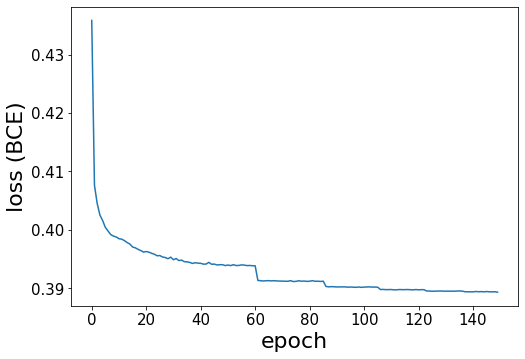

In [14]:
plt.plot(bce_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')

In [15]:
net.cpu()
output = net(torch.from_numpy(X))

# torch.save(net.state_dict(), 'bce_net.pt')

iteration through cut values in steps of 20: 100%|██████████| 10/10 [00:35<00:00,  3.60s/block]


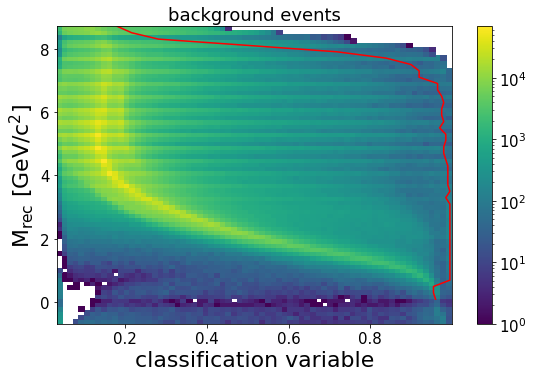

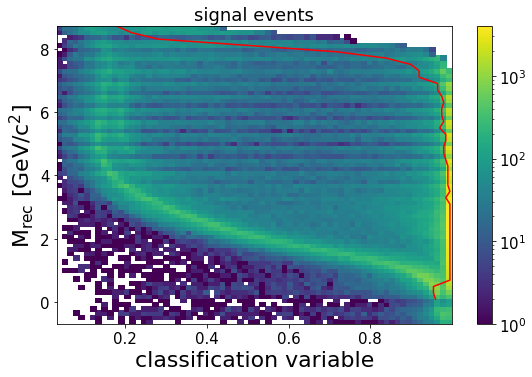

In [16]:
opt_cut_bce, opt_fom_bce = punzinet.fom.optimal_cut(df, output, widths, mass_range, n_gen_signal, scaling=scaling)
punzinet.plot.output_distribution(df, net, X, cut_overlay=opt_cut_bce, mass_range=mass_range)

# second training

In [17]:
net, punzi_loss_list = punzinet.train.punzi_training(df, X, net, len(mass_range), n_gen_signal, target_lumi,  
                                                     device=device, 
                                                     epochs=500, 
                                                     lr=0.05,
                                                     scaling=scaling)

training on cpu


[201] loss: 10.28048:  20%|██        | 201/1000 [04:50<17:08,  1.29s/epochs]

Epoch   201: reducing learning rate of group 0 to 2.5000e-02.


[1000] loss: 9.73619: 100%|██████████| 1000/1000 [22:25<00:00,  1.35s/epochs]


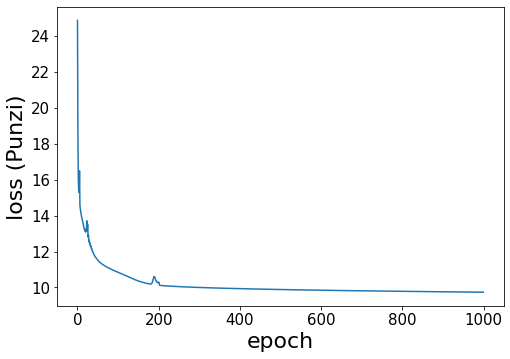

In [18]:
plt.plot(np.array(punzi_loss_list))
plt.xlabel('epoch')
plt.ylabel('loss (Punzi)')
plt.show()

In [19]:
net.cpu()
output = net(torch.from_numpy(X))

# torch.save(net.state_dict(), 'punzi_net.pt')

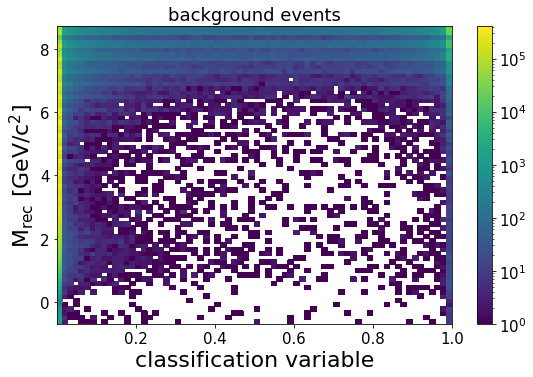

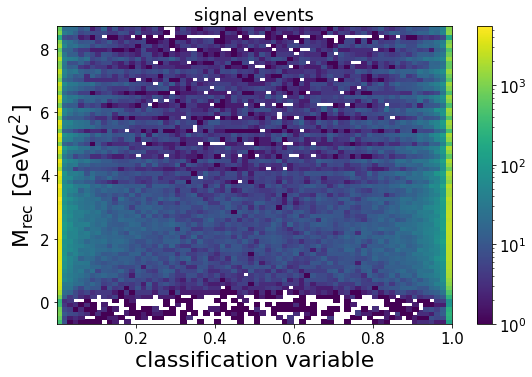

In [20]:
punzinet.plot.output_distribution(df, net, X)

In [21]:
opt_cut_punzi, opt_fom_punzi = punzinet.fom.optimal_cut(df, output, widths, mass_range, n_gen_signal, scaling=scaling)
fom_fixed_cut = punzinet.fom.fixed_cut(df, output, widths, mass_range, n_gen_signal, cut=0.5, scaling=scaling)

iteration through cut values in steps of 20: 100%|██████████| 10/10 [00:11<00:00,  1.17s/block]


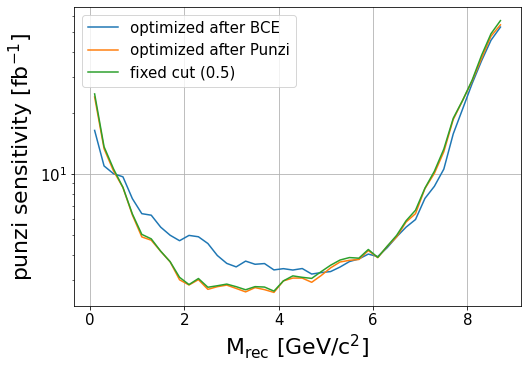

In [22]:
plt.plot(mass_range / 1000, opt_fom_bce, label='optimized after BCE')
plt.plot(mass_range / 1000, opt_fom_punzi, label='optimized after Punzi')
plt.plot(mass_range / 1000, fom_fixed_cut, label='fixed cut (0.5)')
plt.legend()
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.ylabel('punzi sensitivity [fb$^{-1}$]')
plt.xlabel(r'M$_{\sf{rec}}$ [GeV/c$^2$]')
plt.yscale('log')